# Import Needed Modules

In [1]:
!pip install -q segmentation-models-pytorch

import os
import time
from glob import glob
from tqdm import tqdm

import cv2
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import albumentations as A
from scipy.ndimage.morphology import binary_dilation
import segmentation_models_pytorch as smp
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

/home/judy/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_1201868/692059392.py:14: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_dilation


#### Set device to cuda

In [ ]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Data Preprocessing

#### Get all files

In [3]:
files_dir = 'datasets/2/lgg-mri-segmentation/kaggle_3m/'
file_paths = glob(f'{files_dir}/*/*[0-9].tif')

In [4]:
file_paths

['datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_8.tif',
 'datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_24.tif',
 'datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_20.tif',
 'datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_18.tif',
 'datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_3.tif',
 'datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_22.tif',
 'datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_11.tif',
 'datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_12.tif',
 'datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif',
 'datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_14.tif',
 'datasets/2/lgg-mri-segmentation

#### Read csv file of data

In [5]:
csv_path = 'datasets/2/lgg-mri-segmentation/kaggle_3m/data.csv'
df = pd.read_csv(csv_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

#### Missing values handling

In [6]:
imputer = SimpleImputer(strategy="most_frequent")

df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,2.0,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,2.0,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,2.0,0.0
3,TCGA_CS_4944,2.0,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,2.0,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,TCGA_HT_8563,2.0,5.0,3,1.0,2.0,2.0,2,1.0,2.0,1.0,3.0,2.0,1.0,30.0,3.0,2.0,0.0
106,TCGA_HT_A5RC,2.0,4.0,2,2.0,2.0,3.0,2,1.0,2.0,1.0,1.0,2.0,1.0,70.0,3.0,2.0,1.0
107,TCGA_HT_A616,2.0,5.0,2,1.0,2.0,2.0,1,1.0,1.0,1.0,1.0,2.0,1.0,36.0,3.0,2.0,0.0
108,TCGA_HT_A61A,2.0,5.0,2,1.0,2.0,2.0,1,3.0,1.0,1.0,1.0,6.0,1.0,20.0,3.0,2.0,0.0


#### Function to get data

In [7]:
def get_file_row(path):
    """Produces ID of a patient, image and mask filenames from a particular path"""
    path_no_ext, ext = os.path.splitext(path)
    filename = os.path.basename(path)
    
    patient_id = '_'.join(filename.split('_')[:3]) # Patient ID in the csv file consists of 3 first filename segments
    
    return [patient_id, path, f'{path_no_ext}_mask{ext}']

In [8]:
# Show sample
get_file_row('datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif')

['TCGA_DU_7010',
 'datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif',
 'datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45_mask.tif']

#### Store the data into a dataframe

In [9]:
filenames_df = pd.DataFrame((get_file_row(filename) for filename in file_paths), columns=['Patient', 'image_filename', 'mask_filename'])
filenames_df

,Patient,image_filename,mask_filename
0,TCGA_CS_5396,datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA...,datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA...
1,TCGA_CS_5396,datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA...,datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA...
2,TCGA_CS_5396,datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA...,datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA...
3,TCGA_CS_5396,datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA...,datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA...
4,TCGA_CS_5396,datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA...,datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA...
...,...,...,...
3924,TCGA_HT_7686,datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA...,datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA...
3925,TCGA_HT_7686,datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA...,datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA...
3926,TCGA_HT_7686,datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA...,datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA...
3927,TCGA_HT_7686,datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA...,datasets/2/lgg-mri-segmentation/kaggle_3m/TCGA...


## Dataset Class

In [10]:
class MriDataset(Dataset):
    def __init__(self, df, transform=None, mean=0.5, std=0.25):
        super(MriDataset, self).__init__()
        self.df = df
        self.transform = transform
        self.mean = mean
        self.std = std
        
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx, raw=False):
        row = self.df.iloc[idx]
        img = cv2.imread(row['image_filename'], cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(row['mask_filename'], cv2.IMREAD_GRAYSCALE)
        if raw:
            return img, mask
        
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            image, mask = augmented['image'], augmented['mask']
        
        img = T.functional.to_tensor(img)
        mask = mask // 255
        mask = torch.Tensor(mask)
        return img, mask

In [11]:
df = pd.merge(df, filenames_df, on="Patient")

### Split data into train, valid, and test

In [12]:
train_df, test_df = train_test_split(df, test_size=0.3)
test_df, valid_df = train_test_split(test_df, test_size=0.5)

### Transforming
- Only applied channel dropout and random color changes, the model gave subpar results when confronted with rotations and flips.

In [13]:
transform = A.Compose([
    A.ChannelDropout(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.ColorJitter(p=0.3),
])

train_dataset = MriDataset(train_df, transform)
valid_dataset = MriDataset(valid_df)
test_dataset = MriDataset(test_df)

### DataLoaders

In [ ]:
batch_size = 15

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

#### Show sample

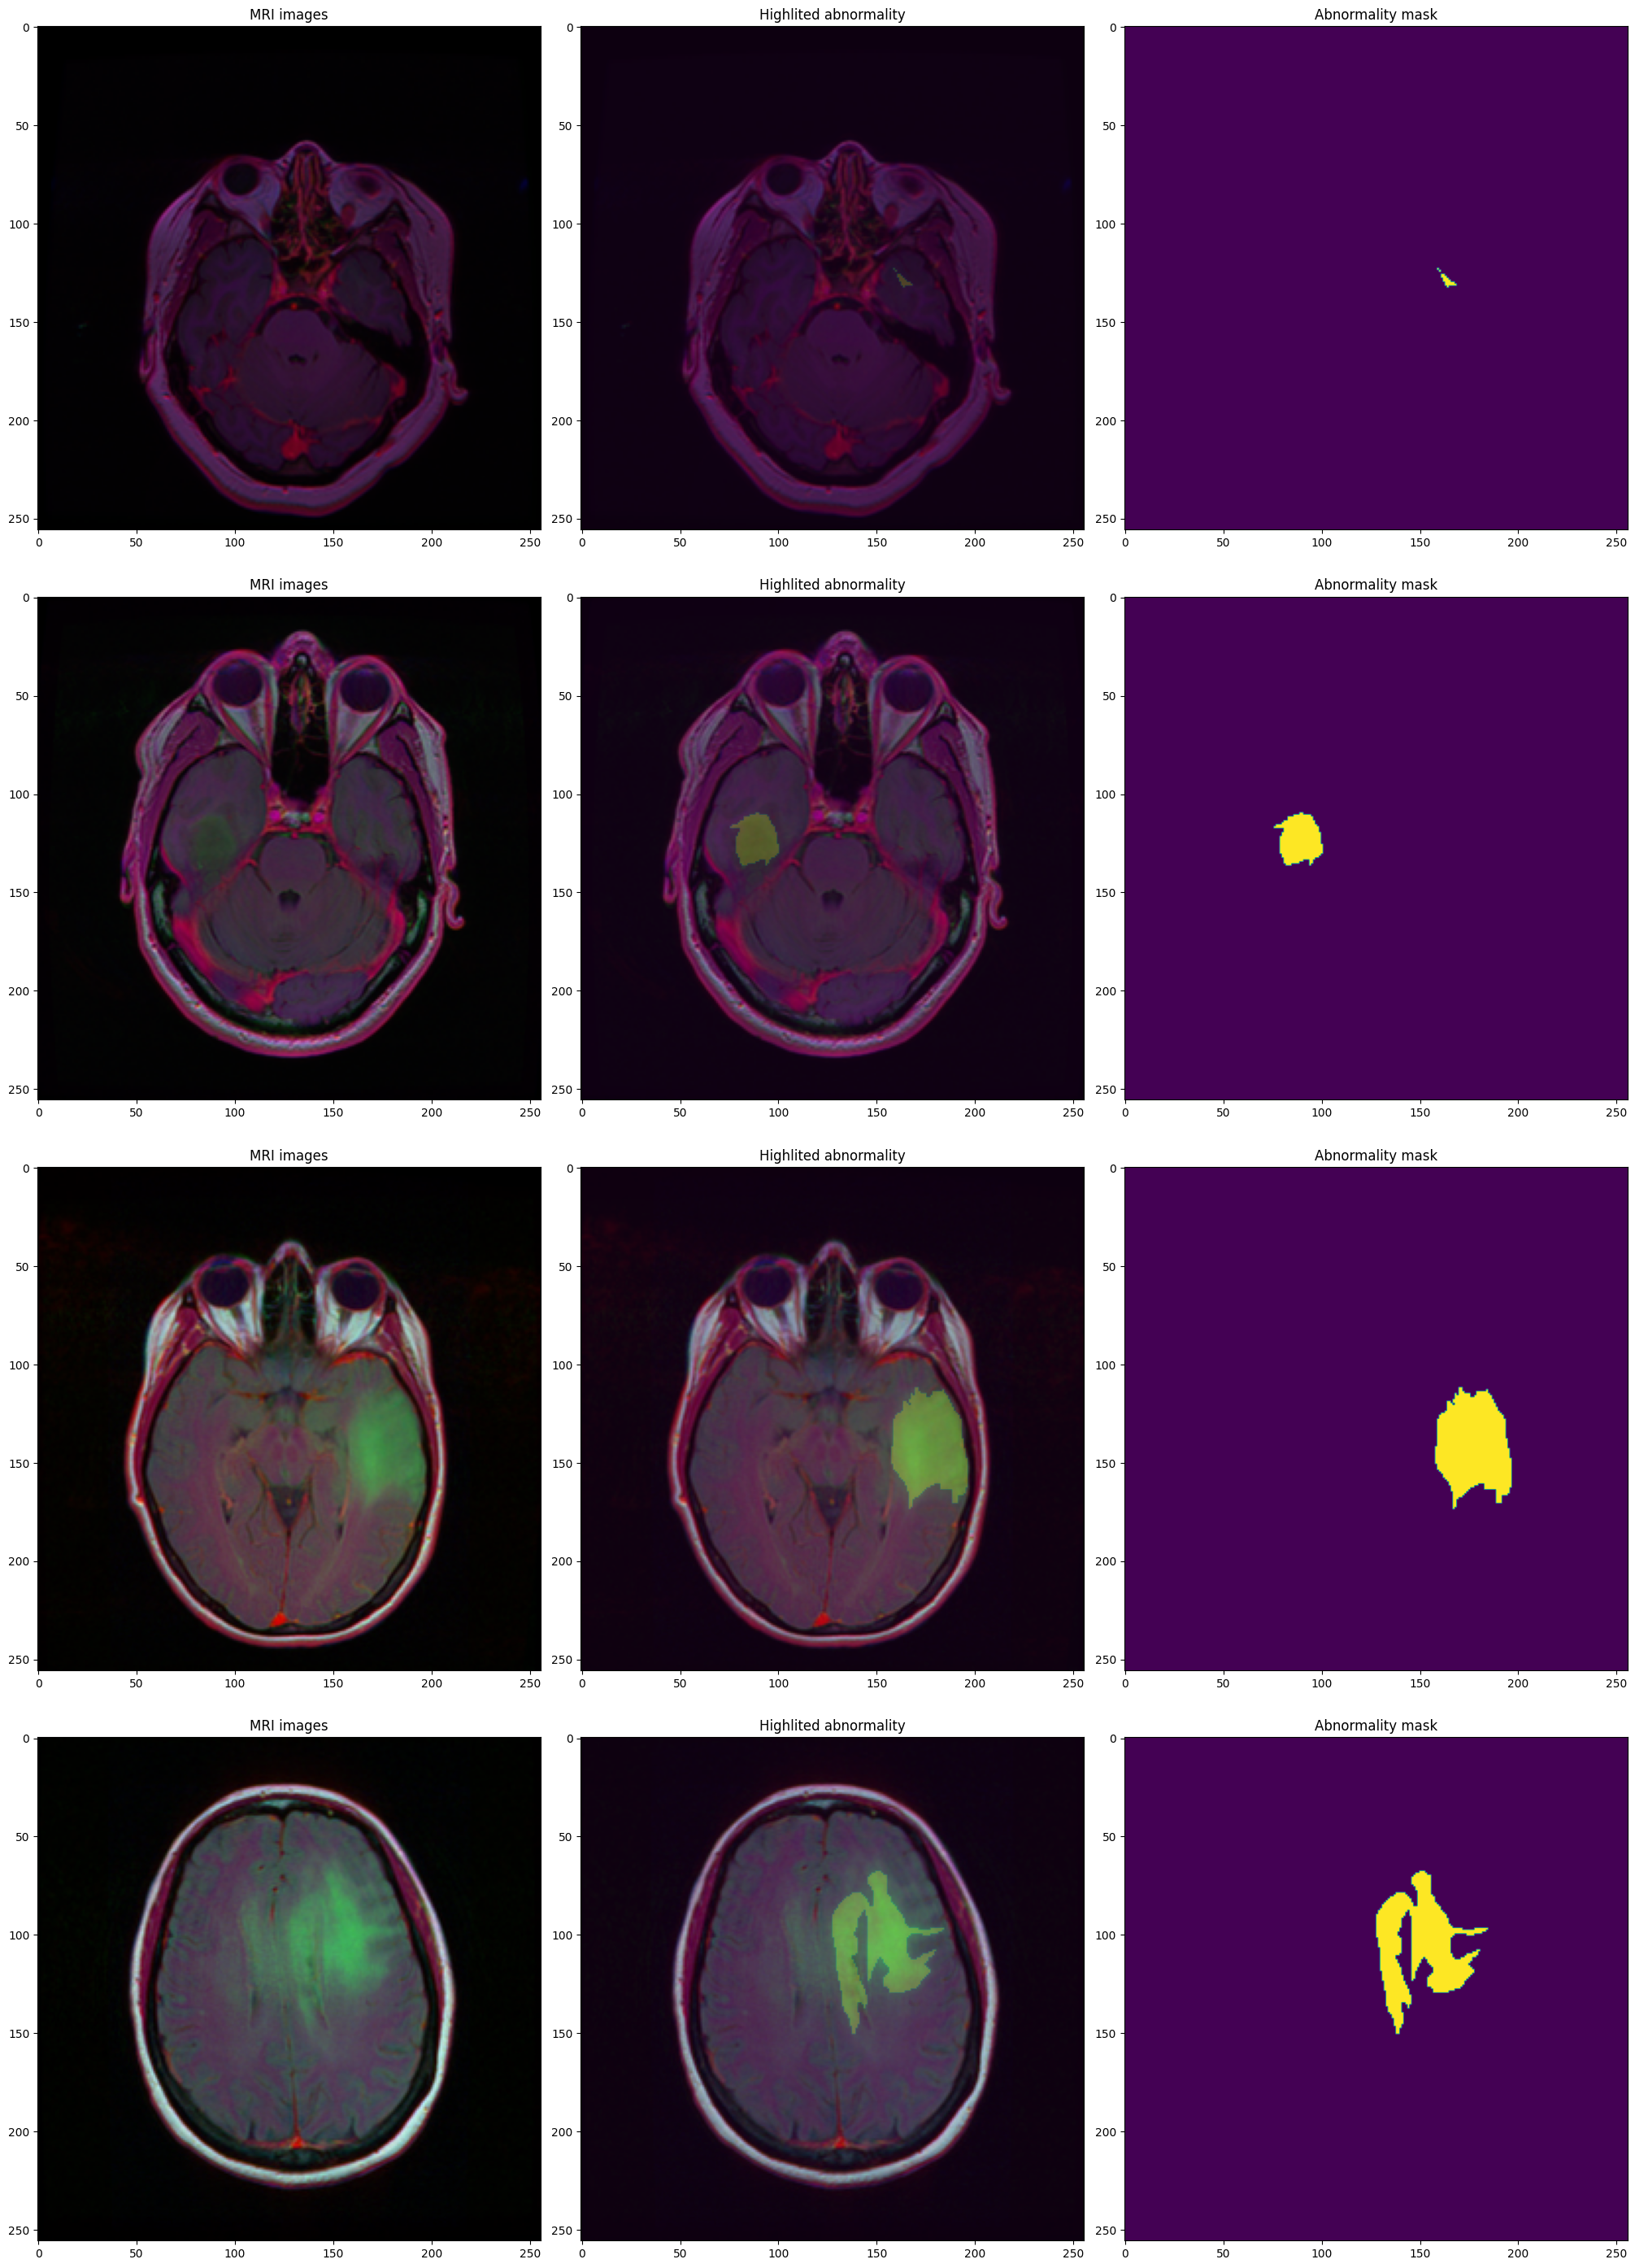

In [15]:
%matplotlib inline
n_examples = 4

fig, axs = plt.subplots(n_examples, 3, figsize=(20, n_examples*7), constrained_layout=True)
i = 0
for ax in axs:
    while True:
        image, mask = train_dataset.__getitem__(i, raw=True)
        i += 1
        if np.any(mask): 
            ax[0].set_title("MRI images")
            ax[0].imshow(image)
            ax[1].set_title("Highlited abnormality")
            ax[1].imshow(image)
            ax[1].imshow(mask, alpha=0.2)
            ax[2].imshow(mask)
            ax[2].set_title("Abnormality mask")
            break

# Model Structure

### Create EarlyStopping class

In [16]:
class EarlyStopping():
    """
    Stops training when loss stops decreasing in a PyTorch module.
    """
    def __init__(self, patience:int = 6, min_delta: float = 0, weights_path: str = 'weights.pt'):
        """
        :param patience: number of epochs of non-decreasing loss before stopping
        :param min_delta: minimum difference between best and new loss that is considered
            an improvement
        :paran weights_path: Path to the file that should store the model's weights
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.weights_path = weights_path

    def __call__(self, val_loss: float, model: torch.nn.Module):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            torch.save(model.state_dict(), self.weights_path)
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def load_weights(self, model: torch.nn.Module):
        """
        Loads weights of the best model.
        :param model: model to which the weigths should be loaded
        """
        return model.load_state_dict(torch.load(self.weights_path))
            

### Create metrics

In [17]:
def iou_pytorch(predictions: torch.Tensor, labels: torch.Tensor, e: float = 1e-7):
    """Calculates Intersection over Union for a tensor of predictions"""
    predictions = torch.where(predictions > 0.5, 1, 0)
    labels = labels.byte()
    
    intersection = (predictions & labels).float().sum((1, 2))
    union = (predictions | labels).float().sum((1, 2))
    
    iou = (intersection + e) / (union + e)
    return iou

def dice_pytorch(predictions: torch.Tensor, labels: torch.Tensor, e: float = 1e-7):
    """Calculates Dice coefficient for a tensor of predictions"""
    predictions = torch.where(predictions > 0.5, 1, 0)
    labels = labels.byte()
    
    intersection = (predictions & labels).float().sum((1, 2))
    return ((2 * intersection) + e) / (predictions.float().sum((1, 2)) + labels.float().sum((1, 2)) + e)

### Loss function

In [18]:
def BCE_dice(output, target, alpha=0.01):
    bce = torch.nn.functional.binary_cross_entropy(output, target)
    soft_dice = 1 - dice_pytorch(output, target).mean()
    return bce + alpha * soft_dice

### UNet Model with EfficientNetB7 as a backbone

In [19]:
model = smp.Unet(
    encoder_name="efficientnet-b7",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation='sigmoid',
)
model.to(device);

In [20]:
print(model)

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          64, 16, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          16, 64, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

# Training

In [21]:
def training_loop(epochs, model, train_loader, valid_loader, optimizer, loss_fn, lr_scheduler):
    history = {'train_loss': [], 'val_loss': [], 'val_IoU': [], 'val_dice': []}
    early_stopping = EarlyStopping(patience=7)
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        
        running_loss = 0
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            img, mask = data
            img, mask = img.to(device), mask.to(device)
            predictions = model(img)
            predictions = predictions.squeeze(1)
            loss = loss_fn(predictions, mask)
            running_loss += loss.item() * img.size(0)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        model.eval()
        with torch.no_grad():
            running_IoU = 0
            running_dice = 0
            running_valid_loss = 0
            for i, data in enumerate(valid_loader):
                img, mask = data
                img, mask = img.to(device), mask.to(device)
                predictions = model(img)
                predictions = predictions.squeeze(1)
                running_dice += dice_pytorch(predictions, mask).sum().item()
                running_IoU += iou_pytorch(predictions, mask).sum().item()
                loss = loss_fn(predictions, mask)
                running_valid_loss += loss.item() * img.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        val_loss = running_valid_loss / len(valid_loader.dataset)
        val_dice = running_dice / len(valid_loader.dataset)
        val_IoU = running_IoU / len(valid_loader.dataset)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_IoU'].append(val_IoU)
        history['val_dice'].append(val_dice)
        print(f'Epoch: {epoch}/{epochs} | Training loss: {train_loss} | Validation loss: {val_loss} | Validation Mean IoU: {val_IoU} '
         f'| Validation Dice coefficient: {val_dice}')
        
        lr_scheduler.step(val_loss)
        if early_stopping(val_loss, model):
            early_stopping.load_weights(model)
            break
    model.eval()
    return history

In [22]:
loss_fn = BCE_dice
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 60
lr_scheduler = ReduceLROnPlateau(optimizer=optimizer, patience=2,factor=0.2)

history = training_loop(epochs, model, train_loader, valid_loader, optimizer, loss_fn, lr_scheduler)

  0%|          | 0/86 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 60.00 MiB. GPU 0 has a total capacity of 47.54 GiB of which 2.12 MiB is free. Process 4019029 has 7.35 GiB memory in use. Process 17729 has 336.00 MiB memory in use. Process 395540 has 402.00 MiB memory in use. Process 1101488 has 25.32 GiB memory in use. Including non-PyTorch memory, this process has 14.12 GiB memory in use. Of the allocated memory 13.75 GiB is allocated by PyTorch, and 69.11 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Evaluation

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(history['train_loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.ylim(0, 0.01)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(history['val_IoU'], label='Validation mean Jaccard index')
plt.plot(history['val_dice'], label='Validation Dice coefficient')
plt.legend()
plt.show()

## Test Evaluation

In [ ]:
with torch.no_grad():
    running_IoU = 0
    running_dice = 0
    running_loss = 0
    for i, data in enumerate(test_loader):
        img, mask = data
        img, mask = img.to(device), mask.to(device)
        predictions = model(img)
        predictions = predictions.squeeze(1)
        running_dice += dice_pytorch(predictions, mask).sum().item()
        running_IoU += iou_pytorch(predictions, mask).sum().item()
        loss = loss_fn(predictions, mask)
        running_loss += loss.item() * img.size(0)
    loss = running_loss / len(test_dataset)
    dice = running_dice / len(test_dataset)
    IoU = running_IoU / len(test_dataset)
    
    print(f'Tests: loss: {loss} | Mean IoU: {IoU} | Dice coefficient: {dice}')

# Testing

In [ ]:
%matplotlib inline

width = 3
columns = 10
n_examples = columns * width

fig, axs = plt.subplots(columns, width, figsize=(7*width , 7*columns), constrained_layout=True)
red_patch = mpatches.Patch(color='red', label='The red data')
fig.legend(loc='upper right',handles=[
    mpatches.Patch(color='red', label='Ground truth'),
    mpatches.Patch(color='green', label='Predicted abnormality')])
i = 0
with torch.no_grad():
    for data in test_loader:
        image, mask = data
        mask = mask[0]
        if not mask.byte().any():
            continue
        image = image.to(device)
        prediction = model(image).to('cpu')[0][0]
        prediction = torch.where(prediction > 0.5, 1, 0)
        prediction_edges = prediction - binary_dilation(prediction)
        ground_truth = mask - binary_dilation(mask)
        image[0, 0, ground_truth.bool()] = 1
        image[0, 1, prediction_edges.bool()] = 1
        
        axs[i//width][i%width].imshow(image[0].to('cpu').permute(1, 2, 0))
        if n_examples == i + 1:
            break
        i += 1
